### 第4週、4日目へようこそ - LangGraphを非同期で呼び出す

これが素晴らしいプロジェクトの始まりです！本当にシンプルで非常に効果的です。

#### 概要
LangGraphを非同期で呼び出す（非同期ツールを実行）

- 1. 準備  
インポート、環境変数の読み込み

- 2. ツール
Push通知ツール、Playwrightブラウザツール

- 3. nest_asyncio  
Jupyterノートブック内での非同期イベントループの競合を避けるため、`nest_asyncio`を利用

- 4. ブラウザツールの利用例  
Playwrightツールを使ったWebページのナビゲート・テキスト抽出

- 5. LangGraphのセットアップ
  - チャットボット・ノードはGPT-4o-miniを利用、前述のツール群をLLMにバインド
  - ノード、エッジの設定を行い、LangGraphとしてグラフを構築し可視化

- 6. GradioによるUI実装  
Gradioの`ChatInterface`を使ってWebチャットUIを立ち上げる非同期関数を実装

In [1]:
# import

# 基本
import os
import random
import requests
from dotenv import load_dotenv
from typing import Annotated
#from typing import TypedDict
from typing_extensions import TypedDict
from pydantic import BaseModel

# langchain
from langchain_openai import ChatOpenAI
from langchain.agents import Tool

# langgraph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# 表示
from IPython.display import Image, display
import gradio as gr

In [2]:
load_dotenv(override=True)

True

### 非同期のLangGraph

ツールを実行するには：  
同期： `tool.run（inputs）`  
async： `await tool.arun（inputs）`

グラフを呼び出すには：  
同期： `graph.invoke（state）`  
async： `await graph.ainvoke（state）`

In [3]:
# tool_push 
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

## 追加のインストールステップ - コンピューターに NodeJS と Playwright がない場合

次に、まだ持っていない場合は、コンピューターに NodeJS と Playwright をインストールする必要があります。

ここで手順をご覧ください：
[Node and Playwright setup](../setup/SETUP-node_jp.md)

### NodeJS

```bash
# システムを更新
sudo apt update && sudo apt upgrade -y
# 必要に応じパッケージをインストール
sudo apt install -y curl
# NodeSourceの公式リポジトリを追加
curl -fsSL https://deb.nodesource.com/setup_lts.x | sudo -E bash -
#  Node.js（npmとnpxも含まれる）をインストール
sudo apt install -y nodejs
```

In [4]:
!node --version
!npm --version
!npx --version

v22.19.0
10.9.3
10.9.3


### Playwright 
`uv` なので `ed-donner_agents` フォルダ直下で実行
```bash
uv run playwright install --with-deps chromium
```

## そして今 -  Playwrightをインストールした後、Windows PCユーザー用のヘッドアップ：

次のいくつかのセルを実行している間、Playwrightブラウザが`NotImplementedError`を上げる問題が発生する可能性があります。

これは、Pythonモジュールに移動するときに機能するはずですが、NotebookのWindowsに問題を引き起こす可能性があります。

このエラーがあり、ノートブックを実行したい場合は、非常にハッキーな小さな変更を行う必要があります。 Playwright（以前のセル）を設置した後、これを行う必要があります

1. `ed-donner_agents` の `.venv` フォルダ以下を任意のツールを使用してGrep検索する。
3. `asyncio.set_event_loop_policy(WindowsSelectorEventLoopPolicy())` を検索する。
4. このコードは、`kernelapp.py` というファイルのコード行にある。
5. この行を含む else 節全体をコメントアウトします（以下の抜粋を参照）。  
   ImportError 行の後に "pass" ステートメントがあることを確認してください。
6. 上記の「再起動」ボタンを押してカーネルを再起動します。

```python
        if sys.platform.startswith("win") and sys.version_info >= (3, 8):
            import asyncio

            try:
                from asyncio import WindowsProactorEventLoopPolicy, WindowsSelectorEventLoopPolicy
            except ImportError:
                pass
                # not affected
            #else:
            #    if type(asyncio.get_event_loop_policy()) is WindowsProactorEventLoopPolicy:
            #        # WindowsProactorEventLoopPolicy is not compatible with tornado 6
            #        # fallback to the pre-3.8 default of Selector
            #        asyncio.set_event_loop_policy(WindowsSelectorEventLoopPolicy())
```

これを発見してくれた学生のNicolasさん、そしてこの方法がうまくいったことを確認してくれたKalyanさん、Yakiさん、Zibinさん、Bhaskarさんに感謝します！

そして、追加のヒントを提供してくれたVladislavさんにも感謝します。

別の方法として、Pythonモジュールに移動することができます（とにかく5日目に実行します）

In [5]:
# nest_asyncioの紹介
# Python Asyncコードでは、1つの「イベントループ」を処理するイベントのみを処理できます。
# `nest_asyncio`ライブラリはこれをパッチし、ネストされたイベントループを実行する必要がある場合は、特別な状況に使用されます。
# agentが１つの「イベントループ」で動作して、playwrightがまた別の「イベントループ」で動作するという話らしい。

import nest_asyncio
nest_asyncio.apply()

### LangChainコミュニティ

LangChainの驚くべきことの1つは、その周りの豊かなコミュニティです。

これをチェックしてください：


In [6]:
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

# 「ココ」または「後」で NotImplementedError を入手した場合は、ノートブックの上部にあるヘッズをご覧ください

async_browser =  create_async_playwright_browser(headless=False) # ヘッド「フル」モード
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

#### PlayWrightBrowserToolkitの確認
これらのツールを組み合わせることで、自動化されたブラウザ操作、ウェブスクレイピング、テスト自動化などが実現できる。

- navigate_browser  
指定されたURLにブラウザを移動させる
- previous_webpage  
ブラウザの戻るボタン機能を実行
- current_webpage  
現在表示されているページの情報を取得
- get_elements  
指定されたセレクターに一致する要素を取得
- extract_text  
現在のページまたは指定された要素からテキストコンテンツを抽出
- extract_hyperlinks  
ページ内のすべてのハイパーリンクを抽出
- click_element  
指定された要素をクリックする

In [7]:
for tool in tools:
    print(f"{tool.name}={tool}")

click_element=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/seigi/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>
navigate_browser=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/seigi/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>
previous_webpage=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/seigi/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>
extract_text=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/seigi/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>
extract_hyperlinks=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/seigi/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>
get_elements=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/seigi/.cache/ms-play

In [9]:
# 何気にWSL2のGUI表示がサポートされているっぽい。

# 2つのツールを抜き出す。
tool_dict = {tool.name:tool for tool in tools}
navigate_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")

# フェイクメディアのCNN（笑）がクソ重かったので
# 「【爆速】世界一表示速度が速いホームページ」から以下を選択
await navigate_tool.arun({"url": "https://phiab.com/commentary/probably-the-fastest-web-site-in-the-world/"})

# 現ページからテキストコンテンツを抽出
text = await extract_text_tool.arun({}) # ★ arunが非同期

In [10]:
import textwrap
print(textwrap.fill(text)[:1000] + "...")

Probably the Fastest Website in the World - PHI Contact PHI Book a
Demo Contact Automated Translation Svenska Deutsch Français Español
Italiano 日本語 中文 Search Website Submit About Our Story Background
Management and Board Partnerships National Institute on Aging
Northeastern University Huntsman Cancer Institute UCSF Gladstone
Institutes Lund University Cancer Centre Malmö University Uppsala
University Users Career Products HoloMonitor A Cell Culture Microscope
An Incubator Microscope A Live Cell Imaging System App Suite Cell
Imaging Software Live Cell Assays Cell Counter Cell QC Kinetic Cell
Proliferation Kinetic Cell Motility Kinetic Dose Response Cell
Morphology Single Cell Tracking Wound Healing Fluorescence Accessories
Applications Overview Cancer Research Stem Cells Drug Discovery &
Development Single-Cell Analysis Adherent Cell Counting Cell QC Cell
Proliferation Cell Morphology Cell Migration Cell Motility and
Migration Wound Healing Technology Gentle Live Cell Imaging
Quantitati

### それらをまとめてください

In [11]:
# PlayWright + Pushover
all_tools = tools + [tool_push]

### ステップ1-5

In [12]:
# ステップ1：Stateクラスを定義
class State(TypedDict):    
    messages: Annotated[list, add_messages]

In [13]:
# ステップ2：Stateクラスでグラフビルダーを起動
graph_builder = StateGraph(State)

In [14]:
# ステップ3：Nodeを作成
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(all_tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [15]:
# ステップ4：グラフを作成
# NodeとEdgeを追加してGraphを作成
#graph_builder = StateGraph(State)

# Node
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=all_tools))

# Edge: START → chatbot
graph_builder.add_edge(START, "chatbot")

# Edge: chatbot ⇔ tools (双方向)
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")

# END は必須ではない、終応答を返した時点で遷移が無ければ処理は自然に終了。
# tools_conditionは「finish_reason=="tool_calls"」を判定しへ進むノードを判定するための条件分岐関数

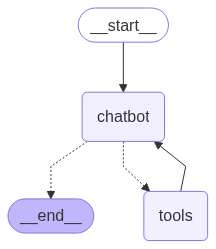

In [16]:
# ステップ5：グラフをコンパイルして可視化
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### それでおしまい！そして、これをしましょう：

「なにかの情報」をプッシュ通知で送ってとプロンプト入力すると良い。  
例えば以下のような（日本語で送るとプッシュ通知はされるが、PlayWrightが動作しなかった）。  
`please send me a push notification with the current USD/GBP exchange rate`

In [17]:
config = {"configurable": {"thread_id": "10"}}

async def chat(user_input: str, history):
    result = await graph.ainvoke({"messages": [{"role": "user", "content": user_input}]}, config=config)  # ★ ainvokeが非同期
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.
